### This is a take at making autoencoder form what is in the internet and comparing with our autencoder to determine where we did wrong.

In [25]:
# import necessary library and modules
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [26]:
# Set up GPU for training....
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [27]:
# Set up data and dataloader
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='./',
                            train=True,
                            transform=transform,
                            download=True)

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=64,
                              shuffle=True)

In [28]:
# Check the range of the data [which is (0 to 1)]
image, label = train_data[0]

torch.min(image), torch.max(image)

(tensor(0.), tensor(1.))

In [29]:
# Define the Linear AutoEncoder Model class
class AutoEncoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [30]:
# Define the CNN AutoEncoder Model class
class AutoEncoder_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 1) # -> N, 64, 1, 1
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # -> N, 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


In [31]:
# Initalize the linear autoencoder  
linear_model = AutoEncoder_Linear().to(device)

# Initalize the cnn autoencoder
cnn_model = AutoEncoder_CNN().to(device)

In [32]:
# Initalize the loss and optimizer for training model

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(linear_model.parameters(),
                             lr=0.001)

schedular = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.1)

In [33]:
optimizer.param_groups[0]['lr']

0.001

In [34]:
# Initalize the flatten model to flatten the image because our linear model takes as input only the linear shaped tensor
flatten = nn.Flatten()

In [35]:
# Check the shape of data as it inputs and outputs (flows through) the model
flattened_tensor = flatten(train_data[0][0]).to(device)
print(f'The flattend tensor shape inputted into model: {flattened_tensor.shape}')
output = linear_model(flattened_tensor)
print(f'The encoded shape of the data: {output[0].shape}')
print(f'The decoded shape of the data: {output[1].shape}')

The flattend tensor shape inputted into model: torch.Size([1, 784])
The encoded shape of the data: torch.Size([1, 3])
The decoded shape of the data: torch.Size([1, 784])


In [36]:
# Train our model
num_epochs = 10

for epoch in range(num_epochs):
    linear_model.train()

    print(f'Epcoh:{epoch+1} | Learning Rate: {optimizer.param_groups[0]['lr']}')

    for index, (image, label)in enumerate(train_dataloader):
        image = image.to(device)

        flat_image = flatten(image)
        
        output = linear_model(flat_image)

        loss = criterion(output[1], flat_image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    schedular.step()

    print(f'Loss: {loss}\n--------')

Epcoh:1 | Learning Rate: 0.001
Loss: 0.052376214414834976
--------
Epcoh:2 | Learning Rate: 0.001
Loss: 0.044566329568624496
--------
Epcoh:3 | Learning Rate: 0.001
Loss: 0.038287606090307236
--------
Epcoh:4 | Learning Rate: 0.001
Loss: 0.036929015070199966
--------
Epcoh:5 | Learning Rate: 0.001
Loss: 0.03417203202843666
--------
Epcoh:6 | Learning Rate: 0.001
Loss: 0.03732401505112648
--------
Epcoh:7 | Learning Rate: 0.001
Loss: 0.0354132354259491
--------
Epcoh:8 | Learning Rate: 0.001
Loss: 0.03879621997475624
--------
Epcoh:9 | Learning Rate: 0.001
Loss: 0.031832922250032425
--------
Epcoh:10 | Learning Rate: 0.001
Loss: 0.03283136337995529
--------


Text(0.5, 1.0, 'Encoded Data Output')

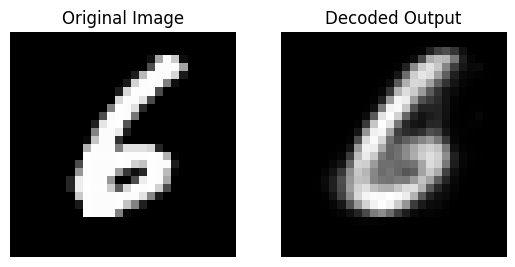

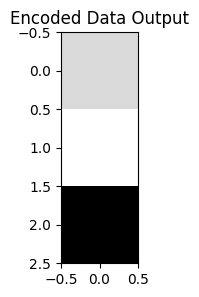

In [37]:
# Visualize the original data/image, encoded output and the decodeded output of the trained model
import random

# picks a random image from our test data and flattens it (making it ready to pass into our linear model)
rand_int = random.choice(range(len(train_data)))
image = train_data[rand_int][0]
flat_image = flatten(image)

# pass the flattend data into the model
model_output = linear_model(flat_image.to(device))

# get the encoded output data and reshape it to plot in graph/image
model_encoded_output = model_output[0]
encoded_output_reshaped = model_encoded_output.reshape(1, -1, 1).detach().cpu()

# get the decode output data and reshape it to plot in graph/image 
model_decoded_output = model_output[1]
decoded_output_reshaped = model_decoded_output.reshape(-1, 28, 28).detach().cpu()

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0), cmap='grey')
plt.title('Original Image')
plt.axis(False)

# plot the decode image
plt.subplot(1, 2, 2)
plt.imshow(decoded_output_reshaped.permute(1, 2, 0), cmap='grey')
plt.title('Decoded Output')
plt.axis(False)

# plot the encoded latent representation
plt.figure(figsize=(3, 3))
plt.imshow(encoded_output_reshaped.permute(1, 2, 0), cmap='grey')
plt.title('Encoded Data Output')

In [38]:
# Get all the predicted labels from the trained model on the train data and store them in 'encoded_data' list  

with torch.inference_mode():

    linear_model.eval()

    encoded_data = []
    label_data = []

    for image, label in train_dataloader:
        image = image.to(device)

        flat_image = flatten(image)
        
        encoded_output = linear_model(flat_image)[0]
        encoded_data.append(encoded_output)
        label_data.append(label)
        
encoded_data = torch.concat(encoded_data)
label_data = torch.concat(label_data)

In [39]:
# Check the shape of the encoded data and their respective true labels
encoded_data.shape, label_data.shape

(torch.Size([60000, 3]), torch.Size([60000]))

# KMEANS Clustering Algorithm starts here

In [40]:
# Apply k-means clustering algorithm on the encoded data to get the get the cluster and cluster labels

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)

cluster_output = kmeans.fit_predict(encoded_data.cpu().numpy())
cluster_output_tensor = torch.tensor(cluster_output)



In [41]:
# Get the confusion matrix between the cluster labels and the true labels of the data

from torchmetrics import ConfusionMatrix

confusion_matrix = ConfusionMatrix(task='multiclass', num_classes=10)

confusion_matrix_tensor = confusion_matrix(cluster_output_tensor, label_data)
confusion_matrix_tensor

tensor([[   0,  889,    0,    0,    0,    0,  106,    4, 4924,    0],
        [2315,   90,  160,    1,  139, 2255,   36,   51,   14, 1681],
        [   0, 1643,   42,    3,   19,    0,  389,  506, 3352,    4],
        [   0, 3266,  101,    4,   36,    0,  203, 2241,  270,   10],
        [   0,    2,  923,    0,   10,    0, 4707,   10,  185,    5],
        [   0, 3091,   56,    0,    0,    0, 1414,  245,  610,    5],
        [   0,  150,    7,    0,    0,    0,   57,    9, 5691,    4],
        [  19,   16, 1088, 2298, 2553,    0,  179,   12,   25,   75],
        [   4, 2105,  249,    1,   12,    0,  327, 2960,  163,   30],
        [   1,  119, 2901,    3,  207,    0, 2569,   29,  109,   11]])

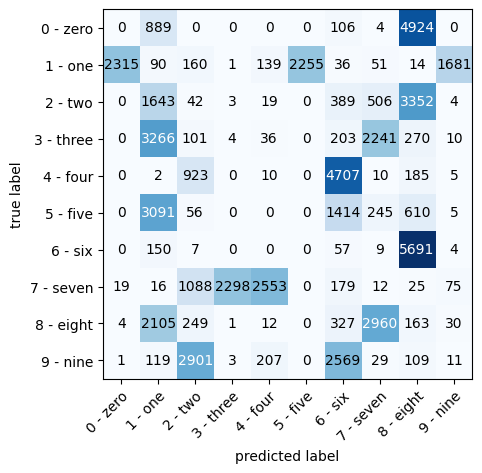

In [42]:
# Plot the kmeans label vs true label confusion matrix

from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(
    conf_mat=confusion_matrix_tensor.numpy(),
    class_names=train_data.classes)

In [52]:
# Store the number of correctly predicted labels in a list
confusion_matrix_tensor[0][0]

total = []
for i in range(len(train_data.classes)):
    correct = confusion_matrix_tensor[i][i].item()
    total.append(correct)

total

[0, 90, 42, 4, 10, 0, 57, 12, 163, 11]

In [53]:
# Calculate the accuracy of the prediction
total_sum = sum(total)
total_sum

acc = (total_sum / len(label_data)) * 100

print(f'Model Accuracy: {acc:.2f} %')

Model Accuracy: 0.65 %


In [69]:
from conf_mat_acc import conf_mat_acc

x = conf_mat_acc(confusion_matrix_tensor=confusion_matrix_tensor, num_labels=len(train_data.classes), len_data=len(train_data))
x

tensor(0.6483)

In [46]:
# Chcek the maximum and minimum value in the 'encoded_data'
encoded_data.max(), encoded_data.min()

(tensor(10.0043, device='cuda:0'), tensor(-46.4555, device='cuda:0'))

In [47]:
encoded_data = encoded_data.cpu()

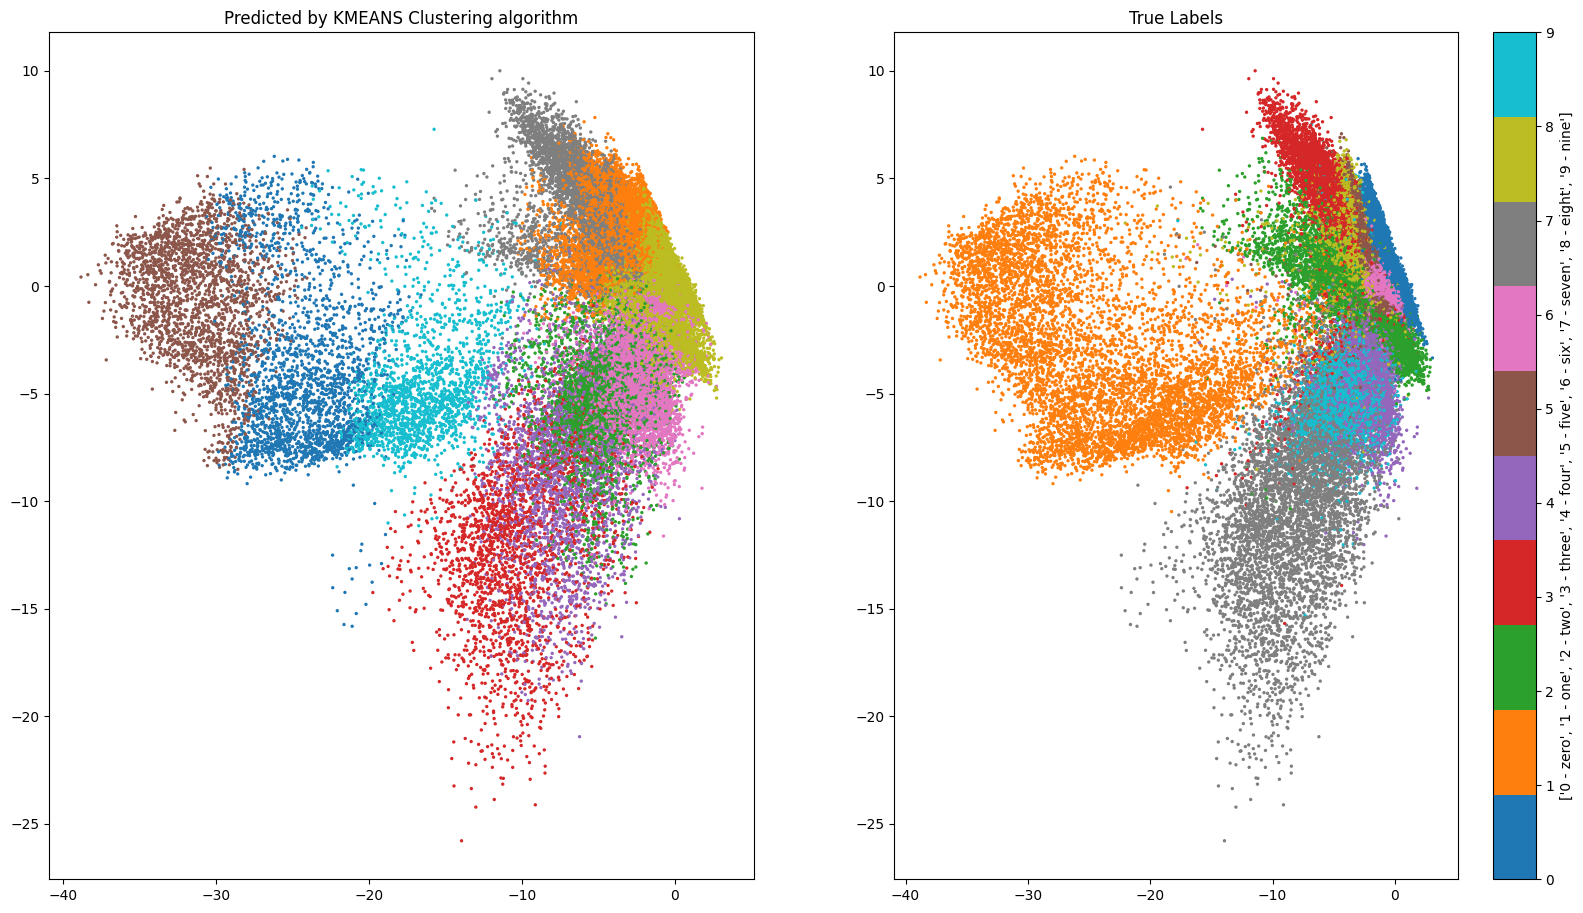

In [48]:
# Since our encoded data is a 2 dimensional vector we can plot it in 2d graph to visualize the data



# Following sample code for plotting in 3d graph
# # Follwing graph gives the predicted labels for the cluster by our clustering algorithm
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# scatter = ax.scatter(encoded_data[:, 0], encoded_data[:, 1], encoded_data[:, 2], c = kmeans.labels_)



fig, ax = plt.subplots(1, 2, figsize=(20, 11))

scatter0 = ax[0].scatter(encoded_data[:, 0], encoded_data[:, 1], c=cluster_output, cmap='tab10', s=2)
ax[0].set_title('Predicted by KMEANS Clustering algorithm')

scatter1 = ax[1].scatter(encoded_data[:, 0], encoded_data[:, 1], c=label_data, cmap='tab10', s=2)
ax[1].set_title('True Labels')

cbar = plt.colorbar(scatter1)
cbar.set_label(train_data.classes)




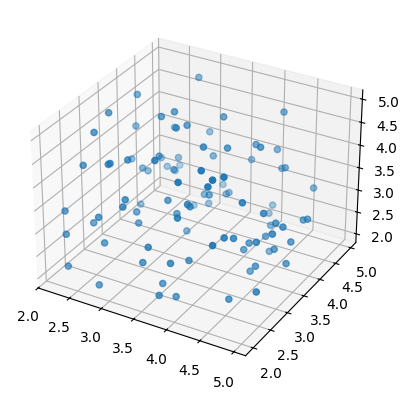

In [49]:
# What the true labels for the cluster should be.....
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})



import torch

a = 2   # lower bound
b = 5   # upper bound
size = (100, 3)  # shape of the tensor

enc = a + (b - a) * torch.rand(size)
'NOTE: torch.rand only generates number between 0 to 1. [0, 1)'

ax.scatter(enc[:, 0], enc[:, 1], enc[:, 2])


# DBSCAN Clustering Algorithm starts here

In [50]:
# Apply DBSCAN clustering algorith to the encoded data ot get the cluster and the cluster labels

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.999, min_samples=5)
db_cluster_output = dbscan.fit_predict(encoded_data.cpu().numpy())
db_cluster_output_tensor = torch.tensor(db_cluster_output)

db_cluster_output_tensor.min(), db_cluster_output_tensor.max()

(tensor(-1), tensor(32))

In [51]:
db_confusion_matrix_tensor = confusion_matrix(db_cluster_output_tensor, label_data)
db_confusion_matrix_tensor

RuntimeError: Detected more unique values in `preds` than expected. Expected only 10 but found 34 in `target`.

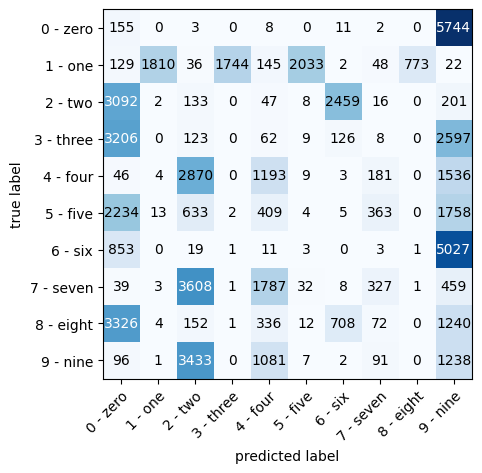

In [ ]:
# Plot the dbcan label vs true label confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=db_confusion_matrix_tensor.numpy(),
    class_names=train_data.classes
)

In [ ]:
# Store the number of correctly predicted labels in a list
db_confusion_matrix_tensor[0][0]

db_total = []
for i in range(len(train_data.classes)):
    correct = db_confusion_matrix_tensor[i][i].item()
    total.append(correct)

db_total

NameError: name 'db_confusion_matrix_tensor' is not defined

In [ ]:
# Calculate the accuracy of the prediction
total_sum = sum(db_total)
total_sum

acc = (total_sum / len(label_data)) * 100

print(f'Model Accuracy: {acc:.2f} %')

Model Accuracy: 8.10 %


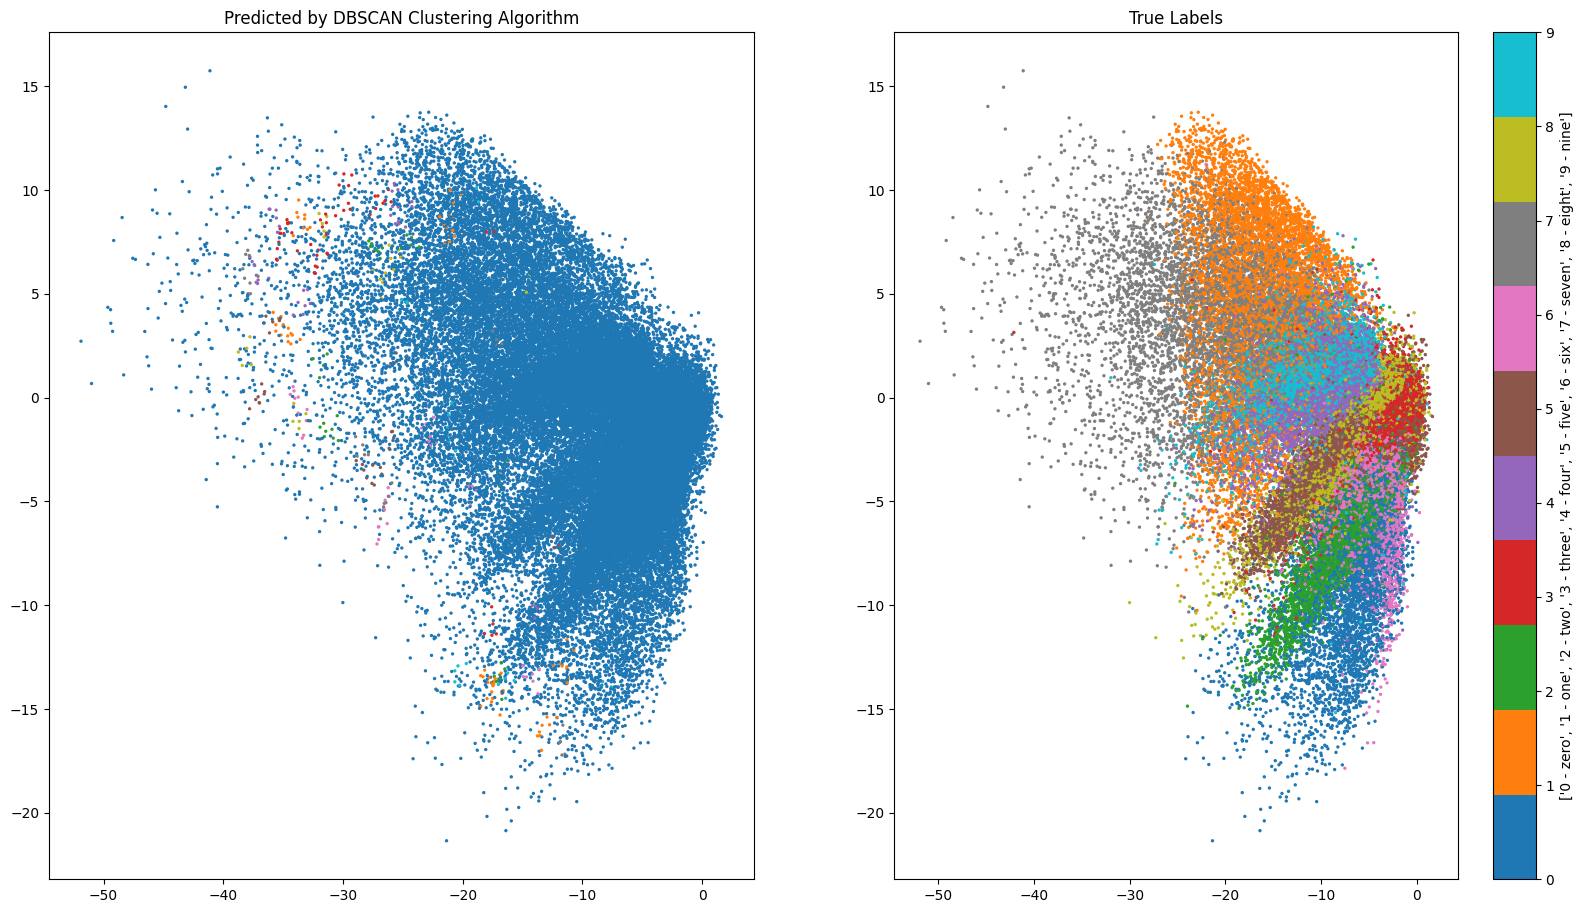

In [ ]:
# Plot the graph between the Predicted labels by the DBSCAN and the true labels


# fig, ax = plt.subplots(1, 2, figsize=(12, 12))

# scatter0 = ax[0].scatter(encoded_data[:, 0], encoded_data[:, 1], c=cluster_output, cmap='tab10')
# ax[0].set_title('Predicted by Clustering algorithm')


fig, ax = plt.subplots(1, 2, figsize=(20, 11))

db_scatter0 = ax[0].scatter(encoded_data[:, 0], encoded_data[:, 1], c=db_cluster_output, cmap='tab10', s=2)
ax[0].set_title('Predicted by DBSCAN Clustering Algorithm')

db_scatter1 = ax[1].scatter(encoded_data[:, 0], encoded_data[:, 1], c=label_data, cmap='tab10', s=2)
ax[1].set_title('True Labels')

cbar = plt.colorbar(db_scatter1)
cbar.set_label(train_data.classes)

# HDBSCAN Clustering Algorithm